<a href="https://colab.research.google.com/github/Ido787/ReadMyLips/blob/develop/Lip_Reading.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Install and Import Dependencies

In [1]:
import os
import cv2
import tensorflow as tf
import numpy as np
from typing import List
from matplotlib import pyplot as plt
import imageio
import gdown
import tempfile
import shutil
from matplotlib import pyplot as plt
from keras.models import Sequential 
from keras.layers import Conv3D, LSTM, Dense, Dropout, Bidirectional, MaxPool3D, Activation, Reshape, SpatialDropout3D, BatchNormalization, TimeDistributed, Flatten
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from google.colab.patches import cv2_imshow

# Configurations

In [2]:
selected_speakers = [1, 5, 19]
data_dir = '/content/data'

# Build Data Loading Functions

Download the speakers from the dataset

In [3]:
invalid_speakers = [21]
base_dataset_URL = 'https://spandh.dcs.shef.ac.uk/gridcorpus'
alignment_dir = f'{data_dir}/alignments'
videos_dir = f'{data_dir}/videos'

# Define the URLs for getting the data
get_videos_url = lambda speaker_index : f'{base_dataset_URL}/s{speaker_index}/video/s{speaker_index}.mpg_vcd.zip'
get_alignments_url = lambda speaker_index : f'{base_dataset_URL}/s{speaker_index}/align/s{speaker_index}.tar'


# Filter all the selected speakers
speakers = [speaker for speaker in selected_speakers if speaker not in invalid_speakers]

# If the alignments or the videos folder were not created
if not (os.path.isdir(alignment_dir) or os.path.isdir(videos_dir)):
  with tempfile.TemporaryDirectory() as tmpdir:
    for speaker_index in speakers:
      print(f'Downloading speaker {speaker_index}:')
      
      alignments_path = f'alignments/s{speaker_index}'
      tf.keras.utils.get_file(None, get_alignments_url(speaker_index), extract=True,
                                      cache_dir=tmpdir, cache_subdir = alignments_path)    
      shutil.move(f'{tmpdir}/{alignments_path}/align', f'{alignment_dir}/s{speaker_index}')

      tf.keras.utils.get_file(None, get_videos_url(speaker_index), extract=True,
                                      cache_dir=tmpdir, cache_subdir = 'videos')    
      shutil.move(f'{tmpdir}/videos/s{speaker_index}', f'{videos_dir}/s{speaker_index}')

421045987/421045987 [==============================] - 23s 0us/step


defining the mouth detection model

In [4]:
!gdown 1OjyocXqGSoNB0HS_PhAE4j2G5YVpwBky
mouth_cascade = cv2.CascadeClassifier('./haarcascade_mcs_mouth.xml')

if mouth_cascade.empty():
  raise IOError('Unable to load the mouth cascade classifier xml file')

Downloading...
From: https://drive.google.com/uc?id=1OjyocXqGSoNB0HS_PhAE4j2G5YVpwBky
To: /content/haarcascade_mcs_mouth.xml
100% 742k/742k [00:00<00:00, 167MB/s]


A function to cut the mouth area of a frame using detection model

In [5]:
def crop_mouth_in_frame(frame):
  ds_factor = 1
  frame = cv2.resize(frame, None, fx=ds_factor, fy=ds_factor, interpolation=cv2.INTER_AREA)
  gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

  mouth_rects = mouth_cascade.detectMultiScale(gray, 1.7, 11)

  for (x,y,w,h) in mouth_rects:
      y = int(y - 0.5*h)
      frame = frame[y:y+h,x:x+w]
      break
  
  frame_resize = cv2.resize(frame, (75,50))
  return frame_resize

Crop and preprocess the video

In [6]:
height_crop = slice(190, 236)
width_crop = slice(80, 220)

# I replaced this function with mine
def crop_frame(frames):
  return frames[height_crop, width_crop, :]

# you didnt use this function
def preprocess_frame(frame):
  new_frame = tf.image.rgb_to_grayscale(frame)

In [7]:
def load_video(path: str) -> List[float]: 
      cap = cv2.VideoCapture(path)
      frames_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

      # Preprocessing
      frames = []

      for _ in range(frames_count): 
          ret, frame = cap.read()
          frame = crop_mouth_in_frame(frame)
          # frame = crop_frame(frame)
          frame = tf.image.rgb_to_grayscale(frame)

          frames.append(frame)

      cap.release()
      
      # Normalize the frames (mean centering)
      mean = tf.math.reduce_mean(frames)
      std = tf.math.reduce_std(tf.cast(frames, tf.float32))

      return tf.cast((frames - mean), tf.float32) / std

Create the vocabulary for the alignments

In [8]:
vocab = [x for x in "abcdefghijklmnopqrstuvwxyz'?!123456789 "]

In [9]:
oov_token=""

# This adds an extra character to the vocab - oov (out of vocabulary) token
char_to_num = tf.keras.layers.StringLookup(vocabulary=vocab, oov_token=oov_token)

num_to_char = tf.keras.layers.StringLookup(
    vocabulary=char_to_num.get_vocabulary(), oov_token=oov_token, invert=True
)

vocab_size = char_to_num.vocabulary_size()

In [10]:
sample_word = "habani"
encoded = char_to_num([*sample_word])

encoded.numpy()

array([ 8,  1,  2,  1, 14,  9])

In [11]:
decoded = num_to_char(encoded)

print("".join([bytes.decode(char) for char in decoded.numpy()]))

habani


In [12]:
special_token = 'sil'

def load_alignments(path: str) -> List[str]: 
    with open(path, 'r') as f: 
        lines = f.readlines() 
    
    tokens = []

    # Extract an array of words seperated by space from the alignment file
    for line in lines:
        start, end, token = line.split()
        
        if token != special_token: 
            tokens = [*tokens, ' ', token]

    return char_to_num(tf.reshape(tf.strings.unicode_split(tokens, input_encoding='UTF-8'), (-1)))[1:]

In [13]:
def load_data(video_path: str):
    # Convert from tensor to string
    video_path = bytes.decode(video_path.numpy())

    alignment_path = video_path.replace("videos", "alignments").replace("mpg","align")
    
    frames = load_video(video_path) 
    alignments = load_alignments(alignment_path)
    
    return frames, alignments

Test the data loading

In [14]:
test_path = './data/videos/s1/bbaf2n.mpg'

In [15]:
frames, alignments = load_data(tf.convert_to_tensor(test_path))

<tf.Tensor: shape=(21,), dtype=int64, numpy=
array([ 2,  9, 14, 39,  2, 12, 21,  5, 39,  1, 20, 39,  6, 39, 20, 23, 15,
       39, 14, 15, 23])>

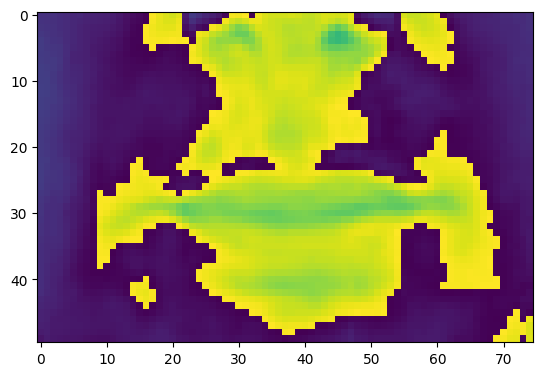

In [16]:
plt.imshow(frames[71])
alignments

In [17]:
tf.strings.reduce_join([bytes.decode(x) for x in num_to_char(alignments.numpy()).numpy()])

<tf.Tensor: shape=(), dtype=string, numpy=b'bin blue at f two now'>

In [18]:
# This is necessary since we might get a prefetch dataset
# or something but we want to access the data eagerly
def mappable_function(path: str) ->List[str]:
    result = tf.py_function(load_data, [path], (tf.float32, tf.int64))
    return result

# 2. Create Data Pipeline

In [20]:
import os
import glob

batch_size = 10
train_percentage = 0.3
amount_from_speaker = 2

sub_dirs = glob.glob(os.path.join(videos_dir, '*'))

selected_data = []

for sub_dir in sub_dirs:
    file_list = glob.glob(os.path.join(sub_dir, '*.mpg'))
    shuffled_files = tf.random.shuffle(file_list)
    num_files = int(len(file_list) / amount_from_speaker)
    selected_files = shuffled_files[:num_files]
    selected_data.extend(selected_files)

data = tf.data.Dataset.from_tensor_slices(selected_data)

data = data.shuffle(len(selected_data))

data_count = len(selected_data)
preprocessed_data = data.map(mappable_function).prefetch(tf.data.AUTOTUNE)

train_count = int(train_percentage * data_count)

train = preprocessed_data.take(train_count).padded_batch(batch_size, padded_shapes=([75,None,None,None],[vocab_size]))
test = preprocessed_data.skip(train_count).padded_batch(batch_size, padded_shapes=([75,None,None,None],[vocab_size]))


In [21]:
print('train', len(train), 'test', len(test))

train 60 test 140


Test data extraction and loading

In [22]:
batch = train.as_numpy_iterator().next()

In [23]:
batched_videos, batched_alignments = batch

In [24]:
sample_video = batched_videos[0]
sample_alignments = batched_alignments[0]

In [25]:
imageio.mimsave('./animation.gif', sample_video, fps=10)

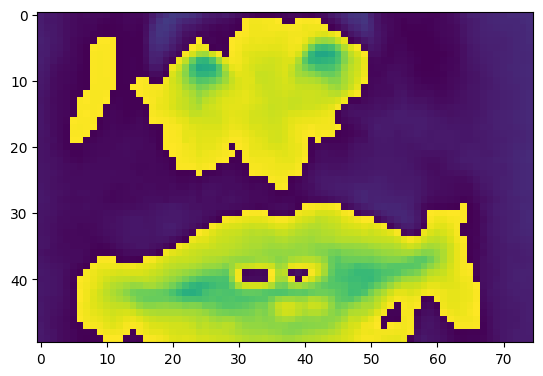

In [26]:
plt.imshow(sample_video[35])

In [27]:
tf.strings.reduce_join([num_to_char(word) for word in sample_alignments])

<tf.Tensor: shape=(), dtype=string, numpy=b'place white at x two please'>

# 3. Design the Deep Neural Network

In [28]:
input_shape = sample_video.shape
input_shape

(75, 50, 75, 1)

In [29]:
model = Sequential()
# Three layers of 3D/spatiotemporal convolutions.
model.add(Conv3D(128, 3, input_shape=input_shape, padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

model.add(Conv3D(256, 3, padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

model.add(Conv3D(75, 3, padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

# Flattens each time slice independently.
model.add(TimeDistributed(Flatten()))

# Two layers of Bi-LSTM's.
# return_sequences=True makes the the network output a sequence of predictions, one for each time step of the input sequence.
model.add(Bidirectional(LSTM(128, kernel_initializer='Orthogonal', return_sequences=True)))
model.add(Dropout(.5))

model.add(Bidirectional(LSTM(128, kernel_initializer='Orthogonal', return_sequences=True)))
model.add(Dropout(.5))

# Linear transformation (dense layer) and output (softmax layer).
model.add(Dense(vocab_size + 1, kernel_initializer='he_normal', activation='softmax'))

In [30]:
model.output_shape

(None, 75, 41)

In [31]:
yhat = model.predict(np.expand_dims(sample_video, axis=0))[0]

1/1 [==============================] - 7s 7s/step


In [32]:
tf.strings.reduce_join([num_to_char(tf.argmax(x)) for x in yhat])

<tf.Tensor: shape=(), dtype=string, numpy=b'uf888888888888888888888888888888888888888888888ff8888888888cccccccccccccccc'>

# 4. Setup Training Options and Train

In [33]:
learning_rate_decay_start_epoch = 100
learning_rate = 0.0003

In [34]:
def scheduler(epoch, lr):
    if epoch < learning_rate_decay_start_epoch:
        return lr
    else:
        return lr * tf.math.exp(-0.01)

In [35]:
def CTCLoss(y_true, y_pred):
    batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
    input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
    label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

    input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
    label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")

    loss = tf.keras.backend.ctc_batch_cost(y_true, y_pred, input_length, label_length)
    return loss

In [36]:
class ProduceExample(tf.keras.callbacks.Callback): 
    def __init__(self, dataset) -> None: 
        self.dataset = dataset.as_numpy_iterator()
    
    def on_epoch_end(self, epoch, logs=None) -> None:
          data = self.dataset.next()
          yhat = self.model.predict(data[0])
          decoded = tf.keras.backend.ctc_decode(yhat, [75,75], greedy=False)[0][0].numpy()
          for x in range(len(yhat)):           
              print('Original:', tf.strings.reduce_join(num_to_char(data[1][x])).numpy().decode('utf-8'))
              print('Prediction:', tf.strings.reduce_join(num_to_char(decoded[x])).numpy().decode('utf-8'))
              print('~'*100)

In [37]:
model.compile(optimizer=Adam(learning_rate=learning_rate), loss=CTCLoss)

In [38]:
checkpoint_callback = ModelCheckpoint(os.path.join('models','checkpoint'), monitor='loss', save_weights_only=True) 

In [39]:
schedule_callback = LearningRateScheduler(scheduler)

In [40]:
train

<_PaddedBatchDataset element_spec=(TensorSpec(shape=(None, 75, None, None, None), dtype=tf.float32, name=None), TensorSpec(shape=(None, 40), dtype=tf.int64, name=None))>

In [41]:
model.fit(train, epochs=5, callbacks=[checkpoint_callback, schedule_callback])

Epoch 1/5
60/60 [==============================] - 486s 8s/step - loss: 108.2944 - lr: 3.0000e-04
Epoch 2/5
60/60 [==============================] - 466s 8s/step - loss: 82.1791 - lr: 3.0000e-04
Epoch 3/5
60/60 [==============================] - 466s 8s/step - loss: 77.2400 - lr: 3.0000e-04
Epoch 4/5
60/60 [==============================] - 465s 8s/step - loss: 75.3150 - lr: 3.0000e-04
Epoch 5/5
60/60 [==============================] - 470s 8s/step - loss: 73.6282 - lr: 3.0000e-04


In [42]:
loss = model.evaluate(test)

140/140 [==============================] - 1516s 8s/step - loss: 69.9847


In [43]:
!zip -r /content/checkpoint.zip /content/models

  adding: content/models/ (stored 0%)
  adding: content/models/checkpoint (deflated 48%)
  adding: content/models/checkpoint.index (deflated 71%)
  adding: content/models/checkpoint.data-00000-of-00001 (deflated 5%)


In [68]:
from google.colab import files
files.download("/content/checkpoint.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [69]:
!du -h /content/checkpoint.zip

66M	/content/checkpoint.zip


# 5. Make a Prediction 

In [44]:
len(test)

140

In [45]:
test_data = test.as_numpy_iterator()

In [ ]:
sample = test_data.next()

In [ ]:
yhat = model.predict(sample[0])

In [ ]:
print('~'*100, 'REAL TEXT')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in sample[1]]

In [ ]:
yhat_tensor = tf.convert_to_tensor(yhat)

In [ ]:
sequence_length = tf.fill([batch_size], tf.shape(yhat)[1])
decoded = tf.keras.backend.ctc_decode(yhat, input_length=sequence_length, greedy=True)[0][0].numpy()

In [ ]:
print('~'*100, 'PREDICTIONS')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in decoded]

In [108]:
model.save_weights("hila")